# iPhone Price Predicition with eBay Data 
Michael Okoronkwo 

July 2025


This post will be another demonstration , albeit nearly all of the work will be done with Python this time.

## Required Libraries

- **`pandas`**: For data manipulation and analysis.
- **`numpy`**: For numerical operations, especially for handling arrays and mathematical functions.
- **`scikit-learn`**: For machine learning models (linear regression & multiple linear regression), data splitting, and evaluation metrics.
- **`seaborn`**: For advanced statistical data visualization.
- **`matplotlib.pyplot`**: For creating static, interactive, and animated visualizations.
- **`re`**: For regular expressions.



## Problem Statement

This demonstration aims to predict the price of iPhones listed on eBay based on their model, variant (e.g. Pro & Pro Max), and condition. By leveraging machine learning techniques, we aim to understand the key factors influencing iPhone prices in the secondary market.

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Load the dataset
try:
    df = pd.read_csv('archive/iphone_ebay.csv')
    print("\nFirst 5 rows of the dataset:")
    print(df.head())
    print("\nInformation about the dataset:")
    df.info()
    print("\nDescriptive statistics of the dataset:")
    print(df.describe())
except FileNotFoundError:
    print("Error: 'iphone_ebay.csv' not found. Please ensure the file is in the correct directory.")
    exit() # Exit if the file isn't found



First 5 rows of the dataset:
                                                name             price  \
0  Apple iPhone 12 Pro Max 5G - 128GB 256GB - A23...  $489.00to$529.00   
1  Apple iPhone 12 - 64GB - Black (Unlocked) A217...           $435.99   
2  Apple iPhone 12 Pro Max 5G A2342 - 128GB 256GB...           $579.00   
3  Apple iPhone XR - 64GB - All Colors - Factory ...           $224.99   
4  Apple iPhone XR 64GB Unlocked Smartphone - Ver...           $184.95   

                 condition  
0       Good - Refurbished  
1                Brand New  
2  Very Good - Refurbished  
3  Very Good - Refurbished  
4  Very Good - Refurbished  

Information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752 entries, 0 to 1751
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       1752 non-null   object
 1   price      1752 non-null   object
 2   condition  1752 non-null   object
dtypes: object(3)


In [3]:
# Check for missing values and duplicates
print(f"\nNull values before cleaning:\n{df.isnull().sum()}")
print(f"\nNumber of duplicate rows: {df.duplicated().sum()}")

df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace = True)
print(f"Number of rows after dropping duplicates: {len(df)}")


Null values before cleaning:
name         0
price        0
condition    0
dtype: int64

Number of duplicate rows: 531
Number of rows after dropping duplicates: 1221


We have 3 features/columns which all contain strings and zero null values.

> **$\approx$ 62% of our rows have unique listing names, what does that say about the nearly 30% remaining listings ?**
>
> 1. Some (different) sellers are using identical listing names
> 2. Some sellers are relisting their iPhone listings on eBay because they sell numerous iPhones through out the year
> 3. Some sellers relist their individual iPhone until they successfully make a sale
>
> Looking at the first 10 rows of data we can see at least one price range in our `price` feature in dataframe `df`.
{: .notice -- primary}

## Data Cleaning and Feature Engineering 

This part focuses on transforming raw data into usable features for the model, including cleaning the price, encoding the condition, and extracting iPhone model variants.

### Cleaning the `price` column

Earlier we saw that some of the entries in `price` are actually price ranges. This would make any future calculations or models impossible so we will have to come up with a way to handle these ranges. 

Here is how we will handle prices.

All prices
* Convert to a floating point number

Price ranges
* Take average of lower & upper bound

In [4]:
def clean_price(price_str):
    if isinstance(price_str, str):
        numbers = re.findall(r'[\d.]+', price_str.replace('$', '').replace(',', ''))
        if numbers:
            if 'to' in price_str.lower(): 
                if len(numbers) >= 2:
                    return (float(numbers[0]) + float(numbers[1])) / 2
            else:
                return float(numbers[0])
    return np.nan 

df['price_cleaned'] = df['price'].apply(clean_price)
df.dropna(subset=['price_cleaned'], inplace=True)
df.reset_index(drop=True, inplace = True) 

print(f"Rows after cleaning 'price' and dropping NaNs: {len(df)}")
df.head()

Rows after cleaning 'price' and dropping NaNs: 1221


,name,price,condition,price_cleaned
0,Apple iPhone 12 Pro Max 5G - 128GB 256GB - A23...,$489.00to$529.00,Good - Refurbished,509.00
1,Apple iPhone 12 - 64GB - Black (Unlocked) A217...,$435.99,Brand New,435.99
2,Apple iPhone 12 Pro Max 5G A2342 - 128GB 256GB...,$579.00,Very Good - Refurbished,579.00
3,Apple iPhone XR - 64GB - All Colors - Factory ...,$224.99,Very Good - Refurbished,224.99
4,Apple iPhone XR 64GB Unlocked Smartphone - Ver...,$184.95,Very Good - Refurbished,184.95


Using the regular expression function `findall()` we retrieved all price ranges. We did this by : 
1. Checking to see if 'to' appears in the row
    - Using `.lower()` make sure the case of the row doesn't cause any issues
2. Then check if there is at least two matches from our row
3. Take the mean of the lower and upper bound
    - Or just return the single price that was retrieved


Next we will create a quantitative feature from the `condition` feature so that it can be incorporated into our upcoming predictive model.

In [5]:
condition_mapping = {
    'For parts or not working': 0,
    'Used - Fair': 1,
    'Used - Good': 2,
    'Pre-Owned': 2, # Assuming Pre-Owned is similar to 'Used - Good'
    'Used - Very Good': 3,
    'Good - Refurbished': 3, # Assuming Good - Refurbished is similar to 'Used - Very Good'
    'Very Good - Refurbished': 4,
    'Excellent - Refurbished': 5,
    'Brand New': 6
}

df['condition_encoded'] = df['condition'].map(condition_mapping)
df.dropna(subset=['condition_encoded'], inplace=True)
df.reset_index(drop = True, inplace = True) 
df['condition_encoded'] = df['condition_encoded'].astype(int) 

print(f"Rows left after encoding 'condition' and dropping NaNs: {len(df)}")

Rows left after encoding 'condition' and dropping NaNs: 1087


Here I mapped the all possible conditions to an integer in the range of 0 to 6. This is a system of ranking the various conditions, the higher the integer, the higher its assumed value / desirability.

I assigned the integers in our codomain to the feature `condition_encoded` and dropped any NaN values from the feature.

Formally, this process is referred to as **ordinal encoding**.  

Here comes our ugliest block of code so far. Below we create the function `extract_model_name()` in order to create a new feature , `model_name`. Which we will use to create a new dataframe that has the iPhone models ***one-hot encoded*** so that we can incorporate each listings iPhone model into our upcoming predictive model. 

In [6]:
def extract_model_name(name):
    name_lower = name.lower()
    model_match = re.search(r'(?<=iphone)\s*(xr|xs\smax|xs|x|se\s*[2-3]|se)|(([1][1-5]|[3-9])\s*(plus|pro\smax|pro|mini)?)',name_lower)
    model = model_match.group() if model_match else 'Unknown'
    return model

df['model_name'] = df['name'].apply(lambda x: pd.Series(extract_model_name(x).strip()))    
df['model_name'] = df['model_name'].replace('Unknown',np.nan)
df.dropna(subset='model_name' , axis = 0) 

df_processed = pd.get_dummies(df, columns = ['model_name'] , prefix='iPhone', drop_first = False) 

print("\nSample of DataFrame after feature engineering:")

# Display price_cleaned next to 3 of the newly created one-hot encoded 'iPhone_' columns

sample_cols = ['price_cleaned'] + [col for col in df_processed.columns if col.startswith('iPhone')][:3]
print(df_processed[sample_cols].head())


Sample of DataFrame after feature engineering:
   price_cleaned  iPhone_11  iPhone_11 pro  iPhone_11 pro max
0         509.00      False          False              False
1         435.99      False          False              False
2         579.00      False          False              False
3         224.99      False          False              False
4         184.95      False          False              False


**Regular expression refresher**
```python
r'(?<=iphone)\s*(xr|xs\smax|xs|x|se\s*[2-3]|se)|(([1][1-5]|[3-9])\s(plus|pro\smax|pro|mini)?)'
```

**Big picture:** We look for the substring `'iphone'` and then search for the proceeding indicators of the various iphone models. We either match with an X* or SE model OR an iphone 1 to iphone 15 and their variants. 


`(?<=iphone)`
- this code tells the machine to look for the `'iphone'` substring as a "prefix" to our upcoming matches but to *exclude* `'iphone'` from our matches

`(xr|xs\smax|xs|x|se\s*[2-3]|se)|(([1][1-5]|[3-9])`
1. We look for the various x models , making sure to look for xs max before xs to avoid reductively grouping all xs phones under 'xs'
2. For SE models, we first look for 2nd or 3rd generation models, any remaining se listings will fall under `'se'`
3. Or we first look for iphone models 11 to 15 or iphone models 3 - 9 if we still don't have a match

This leaves us with 1039 known models and 48 unknown models. You can verify this before running the lines that replace 'Unknown' in `df['model_name']`. 

```python 
n_models = 0 
old_models = 0 

for x in df['model_name']: 
    if x != 'Unknown': 
        n_models += 1
    else :
        old_models += 1
        continue
print(f'We have {n_models} known models in our dataframe and {old_models} unknown models in our dataframe.') 
```

In [7]:
df.reset_index(drop = True, inplace = True) 

In [8]:
df['model_name'].value_counts()

model_name
12            132
11            128
xr             66
13             57
8              57
x              43
12 pro         43
12 pro max     41
se 2           39
7              39
6              37
13 pro max     34
13 pro         33
14             32
12 mini        31
xs             26
8 plus         25
11 pro         23
5              22
14 plus        19
11 pro max     19
se 3           19
14 pro max     18
se             18
14 pro         17
7 plus         17
13 mini        11
xs max         10
6 plus          7
15              6
15 pro max      5
9               5
4               3
3               3
15 pro          1
Name: count, dtype: int64

In [9]:
df_processed.columns

Index(['name', 'price', 'condition', 'price_cleaned', 'condition_encoded',
       'iPhone_11', 'iPhone_11 pro', 'iPhone_11 pro max', 'iPhone_12',
       'iPhone_12 mini', 'iPhone_12 pro', 'iPhone_12 pro max', 'iPhone_13',
       'iPhone_13 mini', 'iPhone_13 pro', 'iPhone_13 pro max', 'iPhone_14',
       'iPhone_14 plus', 'iPhone_14 pro', 'iPhone_14 pro max', 'iPhone_15',
       'iPhone_15 pro', 'iPhone_15 pro max', 'iPhone_3', 'iPhone_4',
       'iPhone_5', 'iPhone_6', 'iPhone_6 plus', 'iPhone_7', 'iPhone_7 plus',
       'iPhone_8', 'iPhone_8 plus', 'iPhone_9', 'iPhone_se', 'iPhone_se 2',
       'iPhone_se 3', 'iPhone_x', 'iPhone_xr', 'iPhone_xs', 'iPhone_xs max'],
      dtype='object')

<Axes: xlabel='model_name'>

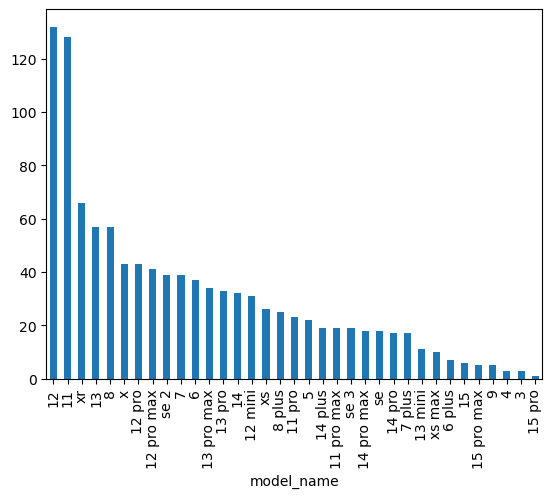

In [10]:
# quick visual representation 
df['model_name'].value_counts().plot.bar()

In [22]:
#number of models
print(f"Number of models in dataframe: {len(df['model_name'].unique())}")

Number of models in dataframe: 36


>*Remark.* I did not discern between different variants of the iPhone 3-5 as I was originally going to exclude older models entirely. While argueably lazy, very few people are actively seeking such old iPhones on the second hand market. Any model that came before the 'plus' variants will just be grouped under the number in the model name.
>
>e.g. The iPhone 3Gs would just fall under `iPhone_3`

## Exploratory Data Analysis (EDA)

This section includes various visualizations to understand the distributions and relationships within the cleaned data.

First we will look at the distribution of prices amongst our cleaned price data and the listings that remain. Utilizing a histogram.

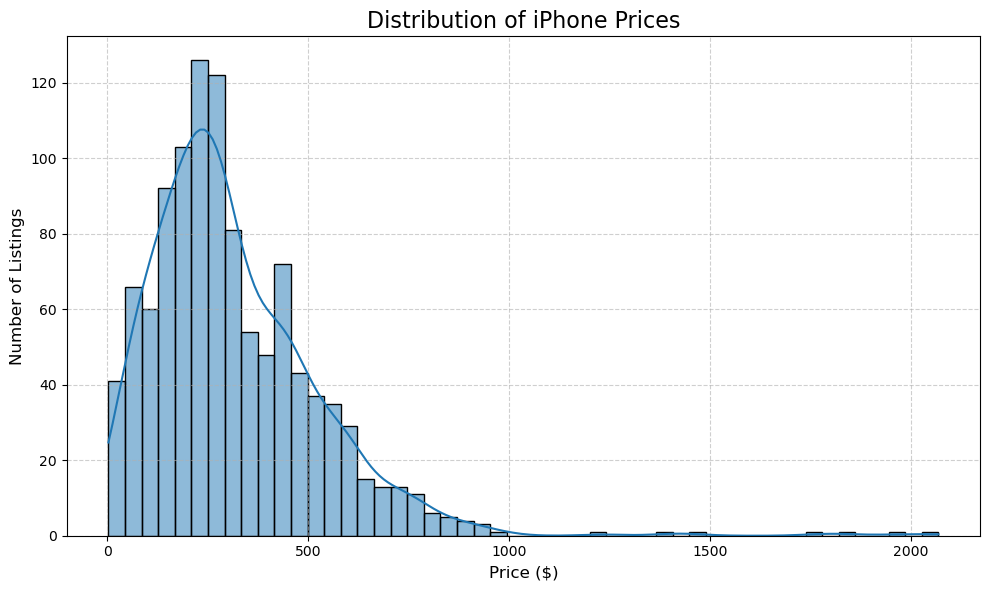

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(df_processed['price_cleaned'], kde=True, bins=50)
plt.title('Distribution of iPhone Prices', fontsize=16)
plt.xlabel('Price ($)', fontsize=12)
plt.ylabel('Number of Listings', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Most of our listings lie within the $[\$0,\$500]$ range. This is likely due to our listings being concentrated in older iPhone models such as the 11, XR, 12, 13, 8 , etc. The extremely cheap listings either fall into the "Pre-Owned" condition or are due to some sort of failure of my code to parse the listing titles effectively.

### Price vs. Condition Boxplot

Here we will create a visual for the distribution of listing prices amongst the various listing conditions. Utilizing a boxplot. 

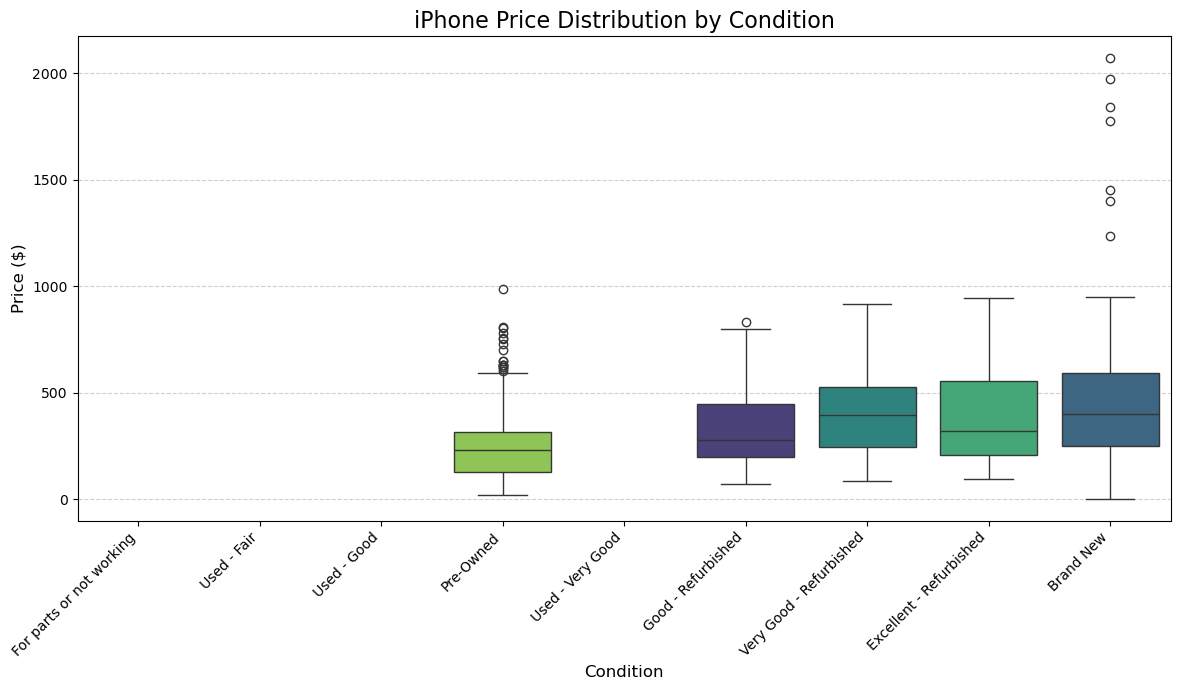

In [13]:
plt.figure(figsize=(12, 7))

condition_labels = {v: k for k, v in condition_mapping.items()} #think of this as an inverse map to our conditiion_mapping map
df_for_condition_plot = df.copy() 
df_for_condition_plot['condition_label'] = df_for_condition_plot['condition_encoded'].map(condition_labels) #mapping encoded output back the original condition strings , placing them in new data frame and feature
sorted_conditions = sorted(condition_mapping.keys(), key=lambda k: condition_mapping[k]) #sorting condition labels using our encoding / numerical values from the condition mapping
sns.boxplot(x='condition_label', y='price_cleaned', data=df_for_condition_plot, order=sorted_conditions, hue = 'condition_label' ,palette='viridis')
plt.title('iPhone Price Distribution by Condition', fontsize=16)
plt.xlabel('Condition', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

We can see that out of the remaining listings, those with "Pre-Owned" or "Brand New" condition tend to have the most outlier prices. As evidenced by all of the points above the upper extreme marker / whisker. 

In [14]:
df_for_condition_plot['condition_label'].value_counts()

condition_label
Pre-Owned                  537
Very Good - Refurbished    166
Good - Refurbished         161
Excellent - Refurbished    113
Brand New                  110
Name: count, dtype: int64

The amount of outliers on the `'Pre-Owned'` condition may be due to the shear amount of listings we have for that condition. That explanation does not really work for the `'Brand New'` conditition , given that it has the least amount of listings. It is possibly due to their being less of a consensus of how to price `'Brand New'` iPhones.

Next, we create a box plot to see the distribution of price amongst the top 15 iPhone models. 

### iPhone Model Variants vs Price 

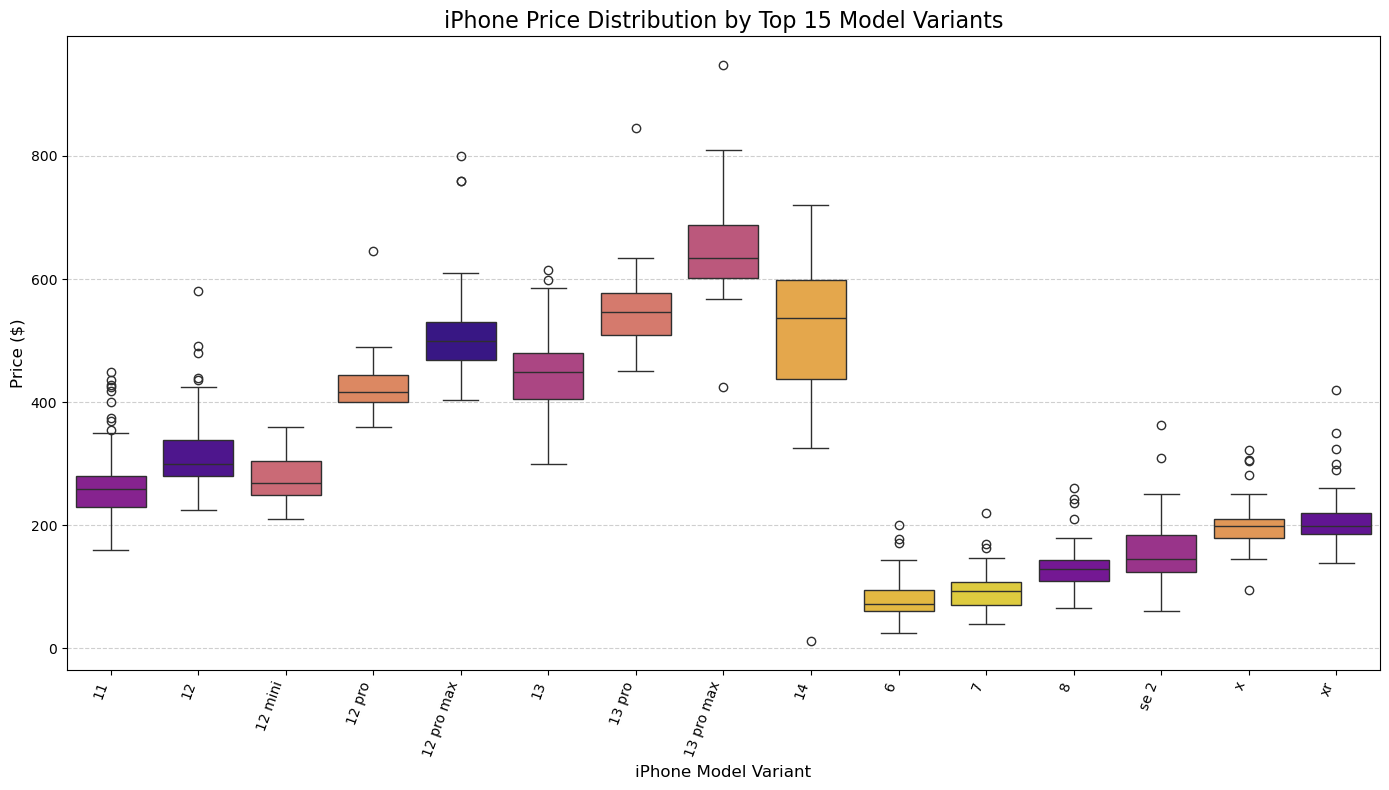

In [15]:
model_counts = df['model_name'].value_counts()
top_models = model_counts.nlargest(15).sort_index().index #returns the name of the top 15 most listed models, sorted

df_top_models = df[df['model_name'].isin(top_models)].copy() 


plt.figure(figsize=(14, 8))
sns.boxplot(x='model_name', y='price_cleaned', data=df_top_models, hue = 'model_name' , palette='plasma',
            order = top_models) 
plt.title(f'iPhone Price Distribution by Top 15 Model Variants', fontsize=16)
plt.xlabel('iPhone Model Variant', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.xticks(rotation=70, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Let's examine some of these outlier prices of our various iPhone models. Recall that an outlier is defined as a point that falls above the upper extreme or below the lower extreme in our box plot. The upper and lower extremes can be determined by the following equations. 

$$\begin{align*} &\text{Upper extreme/whisker} = \text{Upper quartile} +  (IQR \cdot 1.5) \\
&\text{Lower extreme/whisker} = \text{Lower quartile} -  (IQR \cdot 1.5) \end{align*}$$

Where $IQR$ is the interquartile range , the difference between the upper and lower quartiles. 

In [20]:
cols = ['11', '8', 'xr']

for col in cols: 
    df_bxmodel = df[df['model_name'] == col].copy() 
    u_quart = np.percentile(df_bxmodel['price_cleaned'], 75)
    l_quart = np.percentile(df_bxmodel['price_cleaned'], 25)
    IQR = float(u_quart) - float(l_quart) 
    u_extreme = u_quart + (1.5 * IQR)
    l_extreme = l_quart - (1.5 * IQR)
    outliers = [x for x in df_bxmodel['price_cleaned'] if x > u_extreme or x < l_extreme] 
    print(f"\nUpper quartile value for the iPhone {col} is: {u_quart}")
    print(f"\nLower quartile value for the iPhone {col} is: {l_quart}")
    print(f"\nInterquartile range for the iPhone {col} is: {IQR}") 
    print(f"\nNumber of outliers for the iPhone {col} is: {len(outliers)}")
    print("\n ---")


Upper quartile value for the iPhone 11 is: 279.2375

Lower quartile value for the iPhone 11 is: 229.9975

Interquartile range for the iPhone 11 is: 49.24000000000001

Number of outliers for the iPhone 11 is: 9

 ---

Upper quartile value for the iPhone 8 is: 143.6

Lower quartile value for the iPhone 8 is: 109.99

Interquartile range for the iPhone 8 is: 33.61

Number of outliers for the iPhone 8 is: 4

 ---

Upper quartile value for the iPhone xr is: 219.99

Lower quartile value for the iPhone xr is: 184.95

Interquartile range for the iPhone xr is: 35.04000000000002

Number of outliers for the iPhone xr is: 5

 ---


Here we see that out of the three selected models, the iPhone 11 (base model) has the most price outliers and the largest interquartile range. 

### Visualizing Correlation Data 

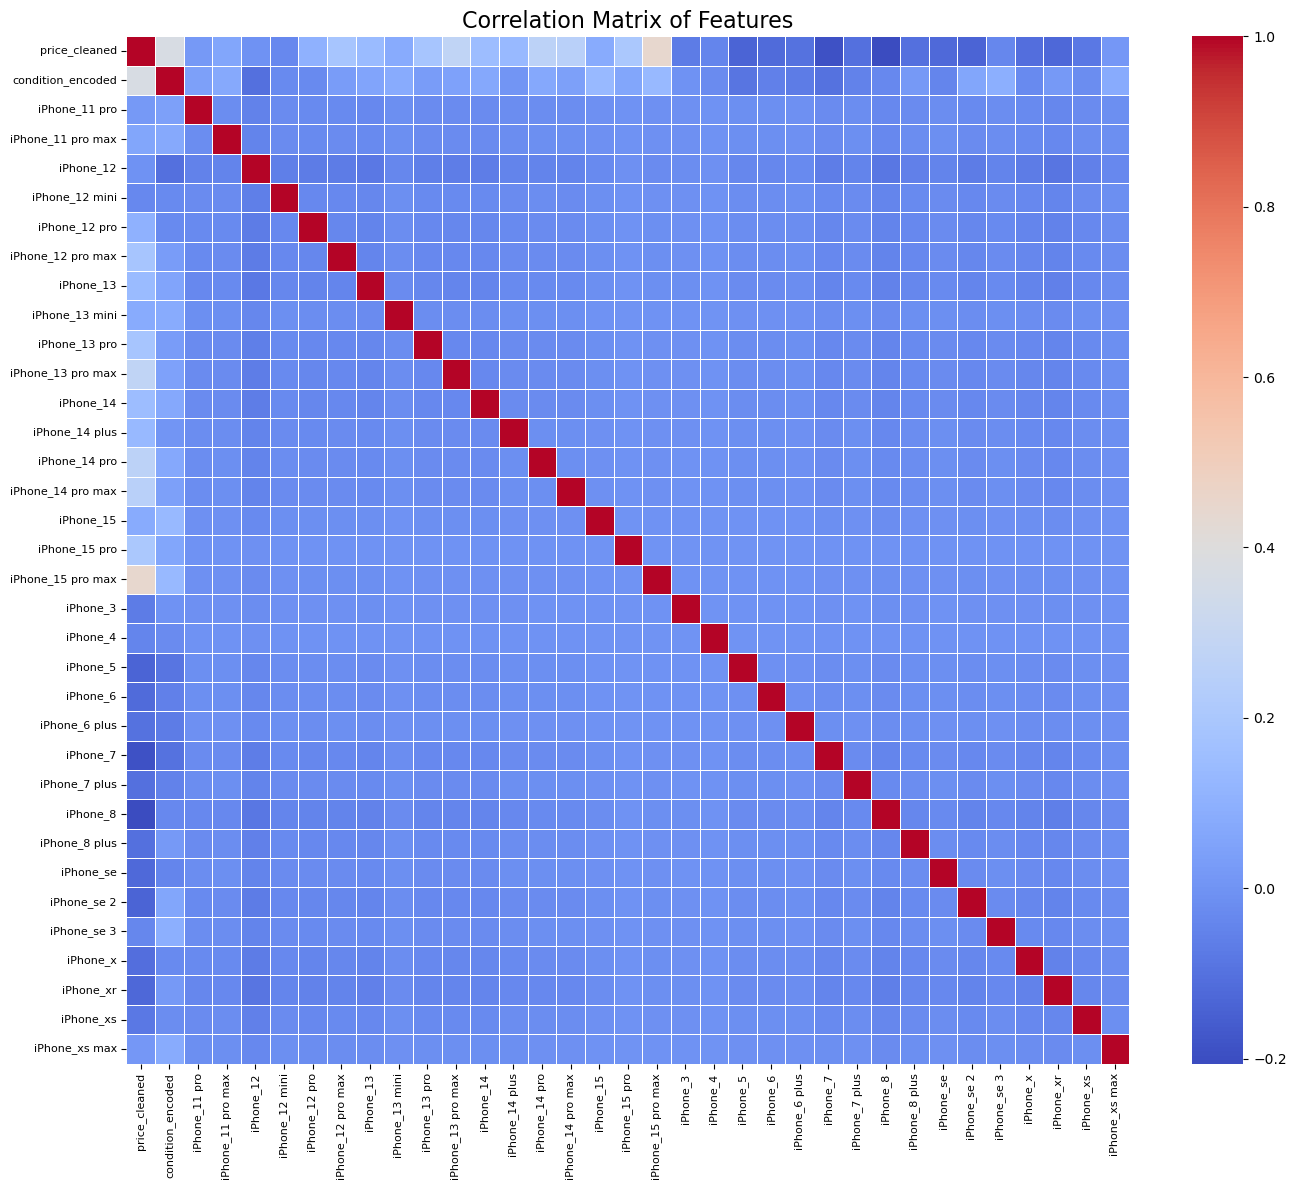

In [14]:
correlation_features = ['price_cleaned', 'condition_encoded'] + [col for col in df_processed.columns if col.startswith('iPhone_')]
corr_matrix = df_processed[correlation_features].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5) # annot=True can make it crowded for many features
plt.title('Correlation Matrix of Features', fontsize=16)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8, rotation=0)
plt.tight_layout()
plt.show()

Here we can see some of the pitfalls of our dataset and the task we wished to complete with it.
Some of the models with the strongest pearson correlation coefficient (in respect to price) have some of the fewest number of listings. Our wide range of model occurences in the data makes for an unbalanced and misleading correlation heatmap. 

## 4. Model Building : Multi-Linear Regression 

A model can be thought of as an equation that is used to predict a value/variable using one or more other variables. Generally we have one target / dependent variable ($y$) and at least 1 predictor/independent variable ($x_i$ where $i \geq 1$).   

**Target / dependent variable ($y$ or $\hat{y}$)** : The variable whose value we attempt to predict with other relevant data points aka predictor variables. 

**Predictor / independent variables** ($x_i$) : The variables used to determine the value of our target variable. 

These values can not be dependent on our target, nor can they be *collinear*. 

Collinearity in a model creates issues for a number of reasons. 
1. We can not be sure of the contributions of each variable to the predictions of the model
2. Collinearity creates redundancy
3. Collinearity results in less predictable model behavior

Coefficients in an model's equation convey the individual contributions of our independent variables on the value of the depedent variable, holding all other variables constant. If we have collinear independent variables then neither can one be held constant if it's also determining the value of the other to a large extent. A small change in our data may result in large changes in the value predicted by our model. 

**Model creation**

To make use of a model we first train/fit the model on sets of training data, this how we get our parameters. In simiple linear regression (i.e. one independent variable and one dependent variable) our parameters simply are the slope of our model's line and the y-intercept of the model. Once we have derived parameters from training, we can predict with the model. 

Generally speaking a model will perform better (i.e. predict accurately and consistently) when we use relevant predictor variables. 

Below we will use the iPhone model/variant and the condition of the listed iPhone as our two predictor variables. We are trying to predict the price of these iPhones, so naturally the target variable is the price. Since we have multiple predictor variables, we are using a Multi-linear regression model. Keep in mind that we have separate columns for each iPhone Model/variant so we will be using upwards of 20 predictor variables.


Note: We will be using `condition_encoded` because a categorical variable such as `condition` has no way of being incorporated into our model otherwise.

**Multi-linear regression**

Method used to explain the relationship between: 
* One continuous target $(\hat{y})$ variable
* Two or more predictor $(x_i)$ variables 

$$\hat{y} = b_0 + b_1 x_1 + b_2 x_2 + \dots b_nx_n$$

*Parameters* 

* $b_0$ :  intercept 
* $b_1$: coefficient of $x_1$ and so on ... 



In [12]:
X_columns = ['condition_encoded'] + [col for col in df_processed.columns if col.startswith('iPhone_')]
X = df_processed[X_columns]
y = df_processed['price_cleaned']

# 80% training data, 20% testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

model = LinearRegression()
model.fit(X_train, y_train)

print("\nModel training complete.")

Training set shape: (869, 34)
Testing set shape: (218, 34)

Model training complete.


## 5. Model Evaluation 

Here we will evaluate the performance of our model by calculating key statistical values and utilizing a number of visuals to aid in our evaluation. 

In [13]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.4f}")

Mean Absolute Error (MAE): 61.06
Mean Squared Error (MSE): 18929.33
Root Mean Squared Error (RMSE): 137.58
R-squared (R2): 0.6190



#### **Mean Absolute Error (MAE):**

$$\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$


#### **Mean Squared Error (MSE):** 
$$\text{MSE } = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y_i})^2  \\ $$   


#### **Root Mean Squared Error (RMSE):**

$$\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$


**Variable Definitions:**

* $n$: The total number of observations (data points) in the dataset.
* $y_i$: The actual (true) value of the dependent variable for the $i$-th observation.
* $\hat{y}_i$: The predicted value of the dependent variable for the $i$-th observation, determined by the iPhone model and condition.


#### **The coefficient of determination ($R^2$):**

$$R^2 = \bigg(1 - \frac{\text{MSE of regression line}}{\text{MSE of the average of the data}} \bigg)$$

### Actual vs Predicted iPhone Prices 

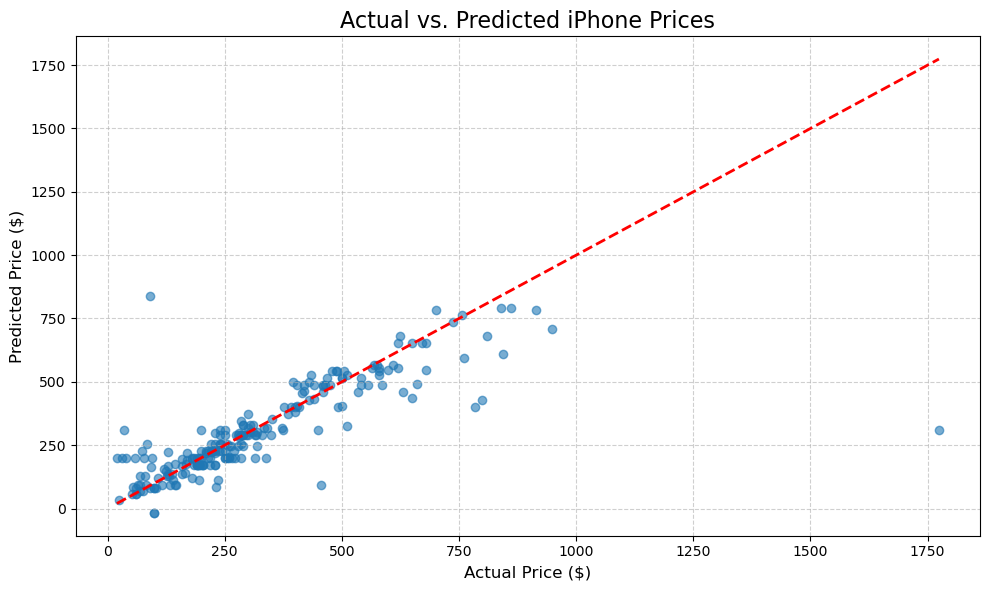

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Diagonal line
plt.title('Actual vs. Predicted iPhone Prices', fontsize=16)
plt.xlabel('Actual Price ($)', fontsize=12)
plt.ylabel('Predicted Price ($)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Here we can observe a lack of a strong systematic bias when looking at how the points fall above and below the diagonal. The overall slope of the scattered points appears close to the 45-degreed diagonal, indicating that the model's scaling of predictions is reasonable.

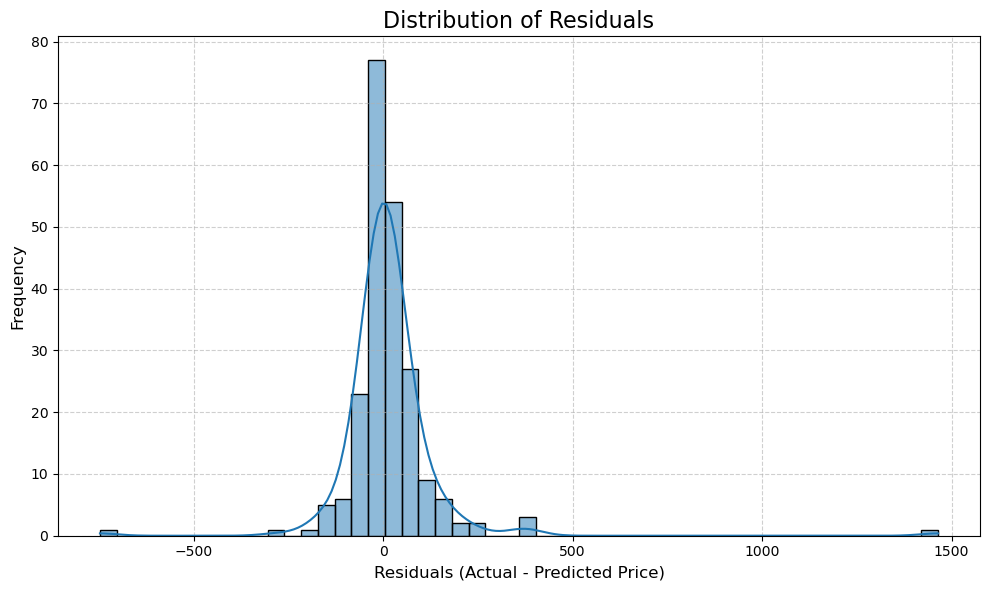

In [18]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=50)
plt.title('Distribution of Residuals', fontsize=16)
plt.xlabel('Residuals (Actual - Predicted Price)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

The majority of the residuals fall within a relatively narrow neighborhood around 0, meaning that most of our predictions were fairly close to the actual price values. Our residuals resemble a normal distribution, albeit with a slightly positive **skewness**. Our prediciton errors appear random, mirroring noise instead of having a systematic pattern to them. These are all signs that we have a linear model that performs decently well. 

Some of the residuals are negative, indicating that the model predicted prices that were higher than the actual values. But in most cases , the model underestimated.

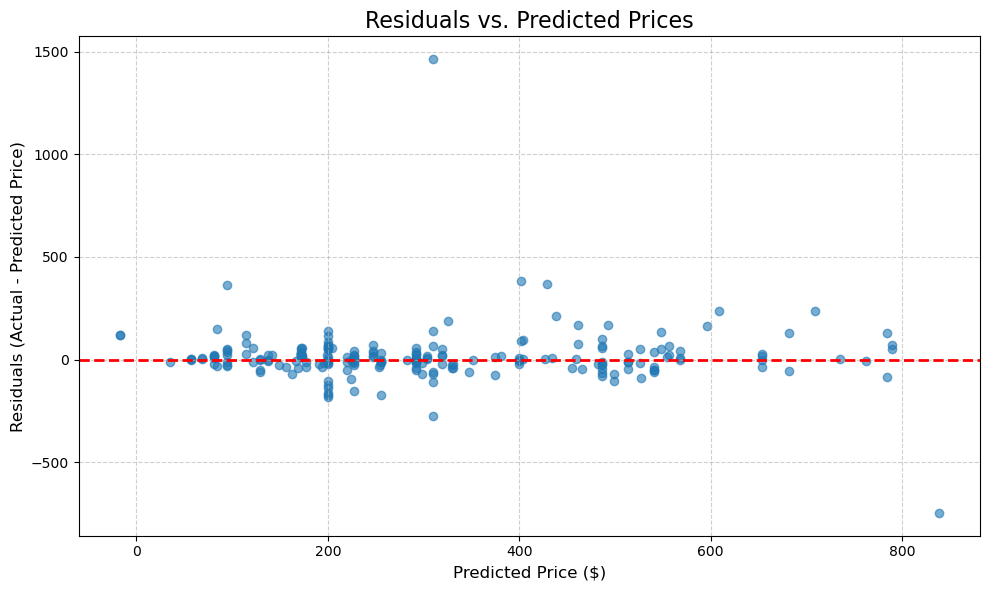

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.title('Residuals vs. Predicted Prices', fontsize=16)
plt.xlabel('Predicted Price ($)', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted Price)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Here we can see that the residuals are mostly scattered around the horizontal line at zero. There doesn't appear to be a significantly non-linear pattern , which likely means that the choice of a linear model (as opposed to a polynomial regression) was a good one. The variance of the errors appears to be constant, the spread of the residuals appears consistent across the domain of predicted prices. Again, this is further evidence that our model is performing decently well. 

## Conclusion 

This demonstration showcased the process of bulding a multi-linear regression model to predict iPhone prices. The model acheived an $R^2$ of $0.6190$ , indicating that it explains a significant portion ($\approx 62 \%$) of the price variance. Meaning that our two chosen features make significant contributions to iPhone prices on the second hand eBay market. The Mean Absolute Error suggests that , on average , predictions are off by $ \approx \$61.$ So while the model performs well relative to the other feature options, I would not use this model for anything other than a demonstration. 

We can see that iPhones listed with higher encoded condition values generally cost more and that more recent iPhone models also tend to cost more. If you want to predict iPhone prices on eBay, you are better off working with relatively recent older models (anything release 2018 or later) as those appear to have the most listings to work with. Due to them being recent enough to not be considered fully deprecated, just dated at worst. 

If we were to blindly go off of values of coefficients and other indicators of correlation we'd be led to believe that the newer models of iPhones are better predictors of price than older models. While this likely is true , we can not assume that with this dataset, given that only a small fraction of the listings we utilized were for iPhone 15s and 14s. 
E.g. $\approx 1.3 \%$ of listings were for iPhone 15s. 

A model's performance is determined by the relevance, size, and "quality" of the data that it can be trained on. If we were to collect more data and work on creating more independent features, we could generate models with higher coefficients of determination ($R^2$) and lower mean average error values. 

**Limitations & Potential Improvements:** 
* We worked with a limited number of feautres.
  * Did not factor storage capacity , color, and/or battery health into our model 
* Unbalanced number of listings per iPhone Model and condition
* Data is static and just a snapshot in time
* A linear model may fail to account for the complexitites of iPhone pricing

Thank you for reading through my demonstration. I hope this post was worth your time. 